In [1]:
## Setup
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from urllib.request import urlopen
import re
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

/anaconda/envs/py35/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 25)
pd.options.display.float_format = '{:,.2f}'.format
plt.rcParams['axes.formatter.useoffset'] = False
#pd.set_option('display.precision',3)

In [3]:
## helper functions

def get_links(url, link_tag):
    try:
        html = urlopen(url)
    except:
        print('Error: use a valid url.')

    soup = BeautifulSoup(html, 'html5lib')


    # Get all the links by using the findAll method with the link_tag as input.
    all_links = soup.findAll(link_tag)

    return all_links

def clean(all_links):
    # Cleanup links by only leaving the actual txt file names.
    clean_links = []
    for link in all_links:
        potential_link = link.get('href')
        file_tag = re.search(r"^data/.+\.txt$", str(potential_link))
        if file_tag:
            comp_link = re.sub(r"data",'http://web.mta.info/developers/data',potential_link)
            clean_links.append(comp_link)

    return clean_links

In [4]:
## import data from June 2016 to June 2017

# all_links = get_links('http://web.mta.info/developers/turnstile.html','a')
# clean_links = clean(all_links)

# counter = 0
# for file_name in clean_links[:53]:
#     if file_name == clean_links[0]:
#         df = pd.read_csv(file_name)
#     else:
#         df = df.append(pd.read_csv(file_name))
#     counter += 1
#     print('finished reading '+ str(counter) + ' weeks of data')

# cols = ['control_area', 'unit', 'scp', 'station', 'linename',\
#         'division', 'date', 'time', 'desc','cum_entries', 'cum_exits']

# df.columns = cols
# df = df.reset_index(drop=True)

## save raw data to csv to avoid downloading again

#df.to_csv('raw_data.csv')
df = pd.DataFrame.from_csv('raw_data.csv') 


In [5]:
df.head()

,control_area,unit,scp,station,linename,division,date,time,desc,cum_entries,cum_exits
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/17/2017,00:00:00,REGULAR,6224816,2107317
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/17/2017,04:00:00,REGULAR,6224850,2107322
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/17/2017,08:00:00,REGULAR,6224885,2107352
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/17/2017,12:00:00,REGULAR,6225005,2107452
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/17/2017,16:00:00,REGULAR,6225248,2107513


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10313053 entries, 0 to 10313052
Data columns (total 11 columns):
control_area    object
unit            object
scp             object
station         object
linename        object
division        object
date            object
time            object
desc            object
cum_entries     int64
cum_exits       int64
dtypes: int64(2), object(9)
memory usage: 944.2+ MB


In [7]:
## understand data structure

In [8]:
# check contents of variables, remove recovered audit data
print(df.desc.value_counts())
print(df.division.value_counts())
df = df[df.desc != 'RECOVR AUD']



REGULAR       10269875
RECOVR AUD       43178
Name: desc, dtype: int64
IRT    3777975
IND    3679462
BMT    2172932
PTH     585976
SRT      74535
RIT      22173
Name: division, dtype: int64


In [9]:
# check turnstile's smallest set of uniquely identifiable variables
# result: a tunstile is unique by control area, scp and station

print(df[['control_area','scp','station']].drop_duplicates().shape)
print(df[['scp','station']].drop_duplicates().shape)
print(df[['control_area','scp','station','unit']].drop_duplicates().shape)


(4801, 3)
(4246, 2)
(4801, 4)


In [10]:
# add datetime variable
df['parsed_datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'], format = '%m/%d/%Y %H:%M:%S')
df.parsed_datetime.describe()

count                10269875
unique                 608678
top       2017-03-23 20:00:00
freq                     2420
first     2016-06-18 00:00:00
last      2017-06-23 23:59:58
Name: parsed_datetime, dtype: object

In [11]:
df.sort_values(['control_area','scp','station','parsed_datetime'])\
.groupby(['control_area','scp', 'station'])['cum_entries']\
.shift(1).isnull().sum()

4801

In [12]:
# add shifted data
df[['shift_cum_entries','shift_cum_exits', 'shift_datetime']] = \
df.sort_values(['control_area','scp','station','parsed_datetime'])\
.groupby(['control_area','scp', 'station'])[['cum_entries','cum_exits','parsed_datetime']]\
.shift(1)

df['entries'] = df['cum_entries'] - df['shift_cum_entries']
df['exits'] = df['cum_exits'] - df['shift_cum_exits']
df = df.sort_values(['control_area','scp','station','parsed_datetime'])
df = df.reset_index(drop=True)
df.head()

,control_area,unit,scp,station,linename,division,date,time,desc,cum_entries,cum_exits,parsed_datetime,shift_cum_entries,shift_cum_exits,shift_datetime,entries,exits
0,A002,R051,02-00-00,59 ST,NQR456,BMT,06/18/2016,00:00:00,REGULAR,5704958,1934814,2016-06-18 00:00:00,nan,nan,NaT,nan,nan
1,A002,R051,02-00-00,59 ST,NQR456,BMT,06/18/2016,04:00:00,REGULAR,5704958,1934829,2016-06-18 04:00:00,"5,704,958.00","1,934,814.00",2016-06-18 00:00:00,0.00,15.00
2,A002,R051,02-00-00,59 ST,NQR456,BMT,06/18/2016,08:00:00,REGULAR,5704958,1934886,2016-06-18 08:00:00,"5,704,958.00","1,934,829.00",2016-06-18 04:00:00,0.00,57.00
3,A002,R051,02-00-00,59 ST,NQR456,BMT,06/18/2016,12:00:00,REGULAR,5704958,1934993,2016-06-18 12:00:00,"5,704,958.00","1,934,886.00",2016-06-18 08:00:00,0.00,107.00
4,A002,R051,02-00-00,59 ST,NQR456,BMT,06/18/2016,16:00:00,REGULAR,5704958,1935069,2016-06-18 16:00:00,"5,704,958.00","1,934,993.00",2016-06-18 12:00:00,0.00,76.00


In [13]:
df.describe()

,cum_entries,cum_exits,shift_cum_entries,shift_cum_exits,entries,exits
count,"10,269,875.00","10,269,875.00","10,265,074.00","10,265,074.00","10,265,074.00","10,265,074.00"
mean,"36,486,262.85","29,139,137.62","36,485,342.67","29,138,523.68","1,518.65","1,242.69"
std,"198,383,992.07","178,412,178.19","198,380,403.78","178,409,702.43","2,718,045.93","2,550,201.08"
min,0.00,0.00,0.00,0.00,"-2,147,369,278.00","-1,777,224,262.00"
25%,"542,339.00","270,255.00","542,371.25","270,277.00",10.00,8.00
50%,"2,646,117.00","1,517,381.00","2,646,139.50","1,517,416.50",76.00,52.00
75%,"6,682,800.00","4,728,312.50","6,682,787.75","4,728,330.00",245.00,165.00
max,"2,147,479,647.00","2,087,386,948.00","2,147,479,647.00","2,087,386,948.00","2,122,192,829.00","2,038,812,708.00"


In [14]:
# make sure the shift is done right
print(df.shift_cum_entries.isnull().nonzero())

turnstile_number = df[['control_area','scp','station']].drop_duplicates().shape[0]
assert turnstile_number == df.shift_cum_entries.isnull().sum()
assert turnstile_number == df.shift_cum_exits.isnull().sum()
assert turnstile_number == df.shift_datetime.isnull().sum()

(array([       0,     2186,     4384, ..., 10263164, 10265402, 10267639]),)


In [15]:
## Sanity check on missing dates

df['parsed_date'] = df.parsed_datetime.map(lambda x: x.date())

assert df.parsed_date.unique().shape[0] == (df.parsed_datetime.max().date() - df.parsed_datetime.min().date()).days +1

In [16]:
## Sanity check on outliers


In [17]:
# describe negative/zero values
print('percentage of negative entries:', "{0:.3f}%".format(df[df.entries < 0].shape[0]/df.shape[0]*100))
print('percentage of zero entries:', "{0:.3f}%".format(df[df.entries == 0].shape[0]/df.shape[0]*100))
print('percentage of negative exits:', "{0:.3f}%".format(df[df.exits < 0].shape[0]/df.shape[0]*100))
print('percentage of zero entries:', "{0:.3f}%".format(df[df.exits == 0].shape[0]/df.shape[0]*100))

percentage of negative entries: 0.744%
percentage of zero entries: 14.631%
percentage of negative exits: 0.603%
percentage of zero entries: 14.345%


In [18]:
# process negative numbers as null, since they account for less than 1% of the data
df.loc[df.entries < 0,'entries'] = np.nan
df.loc[df.exits < 0,'exits'] = np.nan


In [19]:
df[['entries','exits']].describe()

,entries,exits
count,"10,188,648.00","10,203,189.00"
mean,"4,148.48","3,412.00"
std,"2,171,361.98","2,042,769.16"
min,0.00,0.00
25%,11.00,9.00
50%,78.00,53.00
75%,247.00,166.00
max,"2,122,192,829.00","2,038,812,708.00"


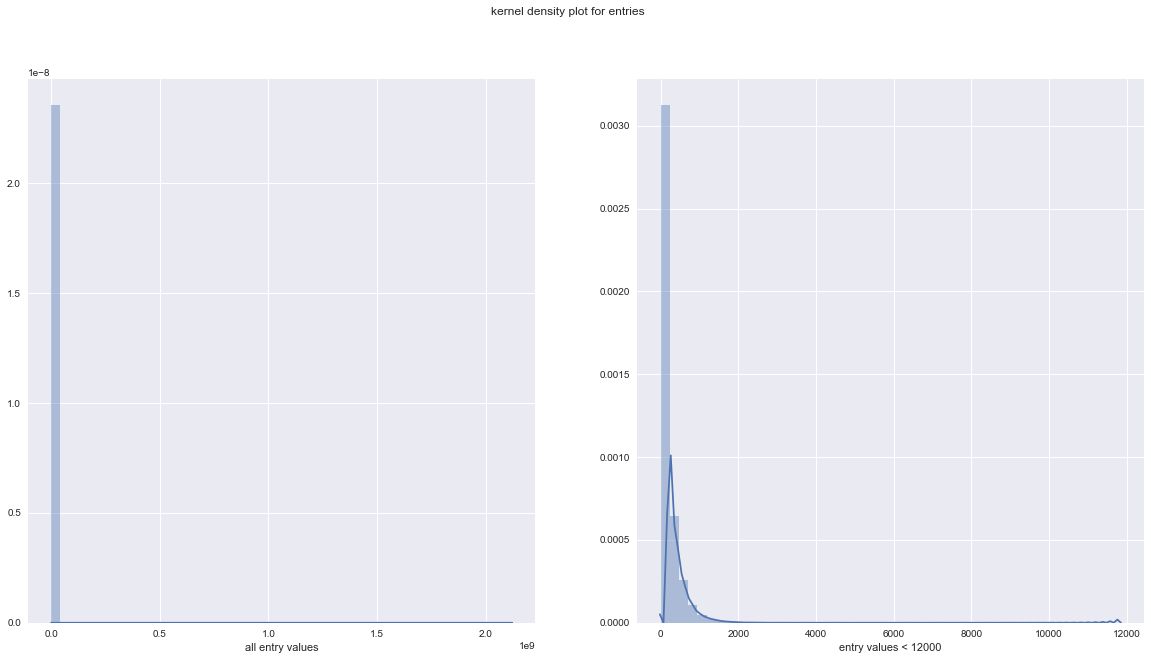

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10));
plt.suptitle('kernel density plot for entries')
sns.distplot(df[df.entries.notnull()].entries, ax=ax[0])
ax[0].set_xlabel('all entry values')

sns.distplot(df[df.entries <12000].entries, ax=ax[1])
ax[1].set_xlabel('entry values < 12000')
fig.savefig('entry_dist.png')


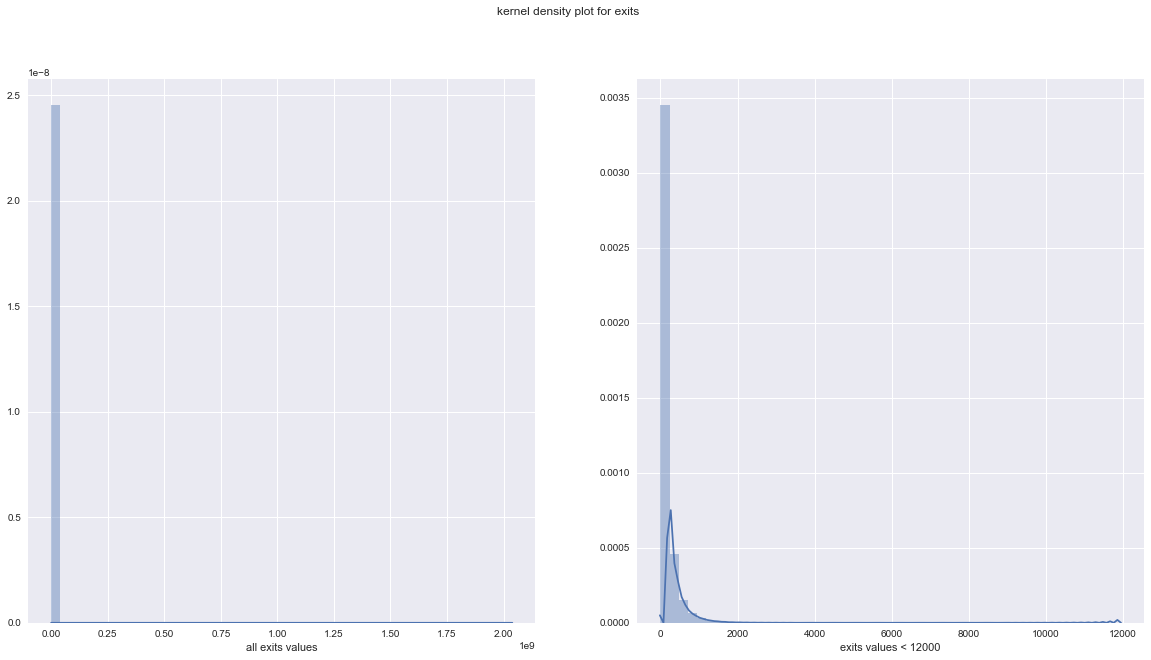

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10));
plt.suptitle('kernel density plot for exits')
sns.distplot(df[df.exits.notnull()].exits, ax=ax[0])
ax[0].set_xlabel('all exits values')

sns.distplot(df[df.exits <12000].exits, ax=ax[1])
ax[1].set_xlabel('exits values < 12000')
fig.savefig('exits_dist.png')

In [22]:
# from the graphs, we find that most of the entry/exits values are less than 4000, 
# we remove outliers by removing any value that is larger than 8000
df.loc[df.entries > 8000,'entries'] = np.nan
df.loc[df.exits > 8000,'exits'] = np.nan

In [23]:
## check data accuracy against MTA public aggregate numbers
# MTA reported that in 2016, average weekday subway ridership was 5.7 million, 
# annual ridership was 1.757 billion

df_days = (df.parsed_date.max() - df.parsed_date.min()).days +1

# billions of ridership in a year infered from daily average
year_ridership = (df.entries.sum()+ df.exits.sum())/df_days*365/10**9/2
print('From June 2016 to June 2017, the yearly ridership is ' + "{0:.2f}".format(year_ridership) + ' billon')

# average weekday ridership (in millons)
weekday_ridership = df[df.parsed_date.map(lambda x: x.weekday() in range(5))].groupby(['parsed_date'])['entries','exits'].sum().mean().mean()/10**6
print('Average weekday ridereship is ' + "{0:.2f}".format(weekday_ridership) + ' millon')

# These numbers are a bit smaller than but close to the number reported by MTA, 
# since the MTA's public number is also questionable on its accuracy, we think
# the current outlier pruning rule is a reasonable one.

From June 2016 to June 2017, the yearly ridership is 1.60 billon
Average weekday ridereship is 5.02 millon


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10269875 entries, 0 to 10269874
Data columns (total 18 columns):
control_area         object
unit                 object
scp                  object
station              object
linename             object
division             object
date                 object
time                 object
desc                 object
cum_entries          int64
cum_exits            int64
parsed_datetime      datetime64[ns]
shift_cum_entries    float64
shift_cum_exits      float64
shift_datetime       datetime64[ns]
entries              float64
exits                float64
parsed_date          object
dtypes: datetime64[ns](2), float64(4), int64(2), object(10)
memory usage: 1.4+ GB


In [25]:
df.describe()

,cum_entries,cum_exits,shift_cum_entries,shift_cum_exits,entries,exits
count,"10,269,875.00","10,269,875.00","10,265,074.00","10,265,074.00","10,188,320.00","10,202,885.00"
mean,"36,486,262.85","29,139,137.62","36,485,342.67","29,138,523.68",180.73,137.62
std,"198,383,992.07","178,412,178.19","198,380,403.78","178,409,702.43",262.63,232.93
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,"542,339.00","270,255.00","542,371.25","270,277.00",11.00,9.00
50%,"2,646,117.00","1,517,381.00","2,646,139.50","1,517,416.50",78.00,53.00
75%,"6,682,800.00","4,728,312.50","6,682,787.75","4,728,330.00",247.00,166.00
max,"2,147,479,647.00","2,087,386,948.00","2,147,479,647.00","2,087,386,948.00","7,975.00","7,972.00"


In [26]:
df.head()

,control_area,unit,scp,station,linename,division,date,time,desc,cum_entries,cum_exits,parsed_datetime,shift_cum_entries,shift_cum_exits,shift_datetime,entries,exits,parsed_date
0,A002,R051,02-00-00,59 ST,NQR456,BMT,06/18/2016,00:00:00,REGULAR,5704958,1934814,2016-06-18 00:00:00,nan,nan,NaT,nan,nan,2016-06-18
1,A002,R051,02-00-00,59 ST,NQR456,BMT,06/18/2016,04:00:00,REGULAR,5704958,1934829,2016-06-18 04:00:00,"5,704,958.00","1,934,814.00",2016-06-18 00:00:00,0.00,15.00,2016-06-18
2,A002,R051,02-00-00,59 ST,NQR456,BMT,06/18/2016,08:00:00,REGULAR,5704958,1934886,2016-06-18 08:00:00,"5,704,958.00","1,934,829.00",2016-06-18 04:00:00,0.00,57.00,2016-06-18
3,A002,R051,02-00-00,59 ST,NQR456,BMT,06/18/2016,12:00:00,REGULAR,5704958,1934993,2016-06-18 12:00:00,"5,704,958.00","1,934,886.00",2016-06-18 08:00:00,0.00,107.00,2016-06-18
4,A002,R051,02-00-00,59 ST,NQR456,BMT,06/18/2016,16:00:00,REGULAR,5704958,1935069,2016-06-18 16:00:00,"5,704,958.00","1,934,993.00",2016-06-18 12:00:00,0.00,76.00,2016-06-18


In [27]:
df.to_csv('clean_data.csv')

In [30]:
#df_new = pd.DataFrame.from_csv('clean_data.csv', parse_dates=['parsed_datetime','parsed_date']) 

/anaconda/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/anaconda/envs/py35/lib/python3.5/site-packages/numpy/lib/arraysetops.py:395: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [29]:
#df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10269875 entries, 0 to 10269874
Data columns (total 18 columns):
control_area         object
unit                 object
scp                  object
station              object
linename             object
division             object
date                 object
time                 object
desc                 object
cum_entries          int64
cum_exits            int64
parsed_datetime      datetime64[ns]
shift_cum_entries    float64
shift_cum_exits      float64
shift_datetime       object
entries              float64
exits                float64
parsed_date          datetime64[ns]
dtypes: datetime64[ns](2), float64(4), int64(2), object(10)
memory usage: 1.5+ GB
